## Learning the Distance Function

In [2]:
ROOT_DIR = "../.."

In [29]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [27]:
import os
import h5py
import numpy as np   
import matplotlib.pyplot as plt
import sys
sys.path.append(ROOT_DIR) 
from tensorflow.keras.utils import plot_model
from cryoem.conversions import euler2quaternion, d_q
from cryoem.angle_recovery import train_angle_recovery
from cryoem.plots import plot_projection, plot_dP_dQ
from cryoem.helpers import train_val_test_split, projections_preprocessing
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8112100349620938180
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11131505856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16767327830705956983
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


### Read data

In [6]:
# full sphere coverage
projections_filename = "../../data/5j0n_full_uniformS2.h5"

# load structures
data_full_5k = h5py.File(projections_filename, 'r')
angles_true = np.array(data_full_5k['Angles'], dtype=np.float32)
projections = np.array(data_full_5k['Projections'], dtype=np.float32)
label = "Full-coverage, Euler uniform"


print(f"{angles_true.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(len(projections)), file_name="../../data/indices.npz")

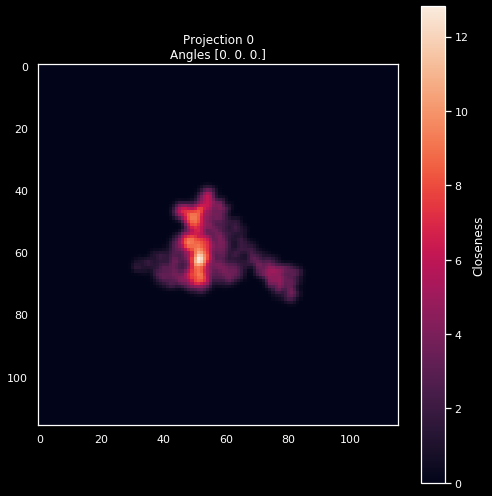

In [9]:
pid = 0
plot_projection(projections[pid], f'Projection {pid}\nAngles {angles_true[pid]}')

In [10]:
settings = dict(
    noise={"variance":16.0},
    shift={"left_limit":-0.01,
           "peak_limit":0,
           "right_limit":0.01},
    channels="gray"
)

In [11]:
X, y = projections_preprocessing(projections, angles_true, settings=settings)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 4.128
Min:  -23.085 | Max: 26.780
Mean: 0.000 | Std: 1.000
Min:  -5.655 | Max: 6.424


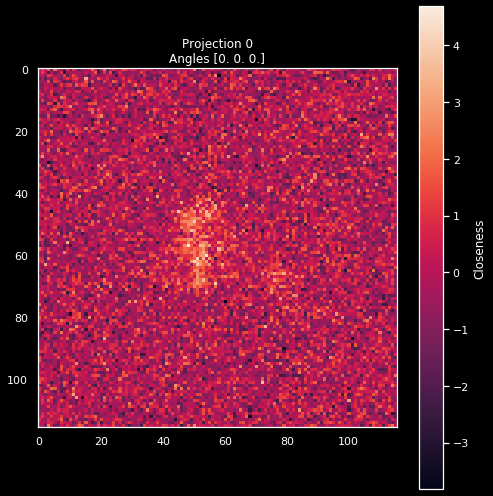

In [12]:
pid = 0
plot_projection(X[pid].squeeze(), f'Projection {pid}\nAngles {y[pid]}')

### Distance Learning

In [13]:
train_percent = 0.01
val_percent = 0.01
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(63101, 7022)

In [ ]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs=100, 
                               batch_size=256, 
                               learning_rate=1e-3, 
                                limit_style="random", 
                                path_logs_training="../../data", 
                                training_description="model",
                               training_steps=int(train_percent*np.power(len(train_idx), 2)), 
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)), 
                               plot=True,
                               gpus=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Data created in 7.587054491043091 sec
Data created in 0.8231291770935059 sec
Input images shape (116, 116, 1)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 512)          4551936     input_10[0][0]                   
                                                                 input_11[0][0

Epoch 46/100
247/247 [==============================] - 150s 607ms/step - loss: 0.1696 - mse: 0.0450 - val_loss: 0.2992 - val_mse: 0.1471
Epoch 47/100
247/247 [==============================] - 151s 610ms/step - loss: 0.1688 - mse: 0.0448 - val_loss: 0.2946 - val_mse: 0.1426
Epoch 48/100
247/247 [==============================] - 150s 608ms/step - loss: 0.1686 - mse: 0.0447 - val_loss: 0.2960 - val_mse: 0.1440
Epoch 49/100
247/247 [==============================] - 150s 608ms/step - loss: 0.1688 - mse: 0.0448 - val_loss: 0.2944 - val_mse: 0.1420
Epoch 50/100
247/247 [==============================] - 150s 606ms/step - loss: 0.1692 - mse: 0.0447 - val_loss: 0.2932 - val_mse: 0.1409
Epoch 51/100
247/247 [==============================] - 149s 603ms/step - loss: 0.1694 - mse: 0.0451 - val_loss: 0.2935 - val_mse: 0.1418
Epoch 52/100
247/247 [==============================] - 150s 607ms/step - loss: 0.1660 - mse: 0.0437 - val_loss: 0.2872 - val_mse: 0.1361
Epoch 53/100
247/247 [============

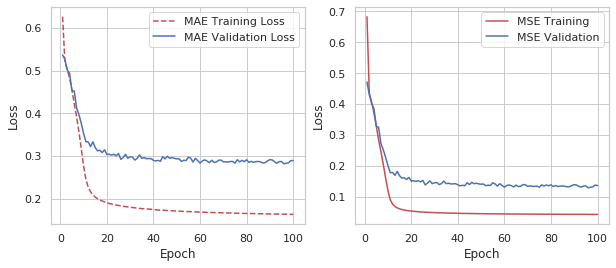

In [21]:
data = np.load("../../data/losses/model.npz")
training_loss, val_loss, mses, val_mses = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

sns.set_style("whitegrid", {'axes.grid' : True})
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [23]:
model.save_weights(f"../../data/training/model_weights.h5")

### Read Model Checkpoint

In [14]:
# put correct filename
model_filename = f"../../data/training/model.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 512)          4551936     input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           model_6[0][0]              

In [22]:
plot_model(model, to_file=f"../../data/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Performance Plot - True vs. Predicted

In [24]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [25]:
idx1 = list(np.random.choice(test_idx, size=5000))
idx2 = list(np.random.choice(test_idx, size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

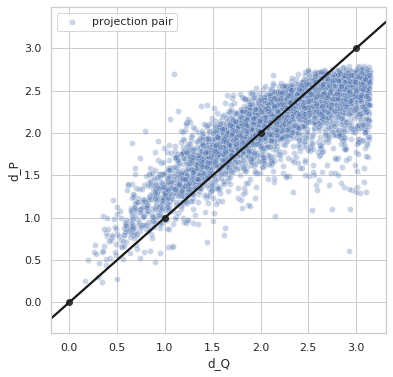

<Figure size 432x288 with 0 Axes>

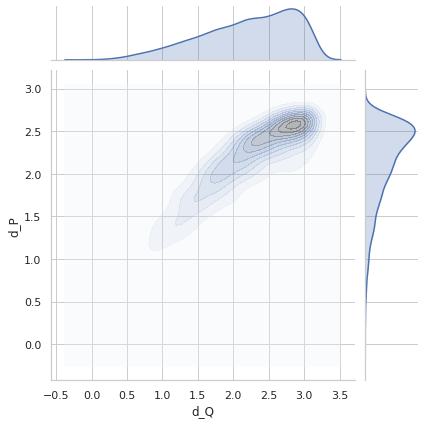

Variance = 0.3650154143785532
Min. angle recovery loss possible = 0.13320960548340013
MAE:  0.28325868


In [28]:
plot_dP_dQ(dP_values, dQ_values)